# github_readme_nlp

In [1]:
# Setup environment
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import os
import time
import pandas as pd
import numpy as np
import unicodedata
import re
import json
import os
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

## Acquire/Prepare

**Task** show steps to acquire and prepare

- original, cleaned, stem, lemmatize notes

In [2]:
df = prepare.prep()

In [3]:
df.head()

,language,title,original,cleaned,stemmed,lemmatized
0,Python,donnemartin/system-design-primer,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...,english readme md readme ja md readme zh hans ...,english readm md readm ja md readm zh han md r...,english readme md readme ja md readme zh han m...
1,Python,TheAlgorithms/Python,# The Algorithms - Python\n\n[![Donate](https:...,algorithms python donate https img shields io ...,algorithm python donat http img shield io badg...,algorithm python donate http img shield io bad...
10,Python,scikit-learn/scikit-learn,.. -*- mode: rst -*-\n\n|Azure|_ |Travis|_ |Co...,mode rst azure travis codecov circleci pythonv...,mode rst azur travi codecov circleci pythonver...,mode rst azure travis codecov circleci pythonv...
100,JavaScript,freeCodeCamp/freeCodeCamp,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp org social banner https amazonaws...,freecodecamp org social banner http amazonaw c...,freecodecamp org social banner http amazonaws ...
101,JavaScript,vuejs/vue,"<p align=""center""><a href=""https://vuejs.org"" ...",p align center href https vuejs org target bla...,p align center href http vuej org target blank...,p align center href http vuejs org target blan...


## Prep Summary

- Create data frame with cleaned data and language listed.

In [4]:
lemmas_df = df[['language', 'title', 'lemmatized']]

## Explore & Define Features

### Category Distribution

In [5]:
lemmas_df.dropna(inplace=True)

In [6]:
lemmas_df.shape

(400, 3)

In [7]:
lemmas_df.language.value_counts(normalize = True)

PHP           0.25
Shell         0.25
JavaScript    0.25
Python        0.25
Name: language, dtype: float64

,n,percent
PHP,100,0.25
Shell,100,0.25
JavaScript,100,0.25
Python,100,0.25


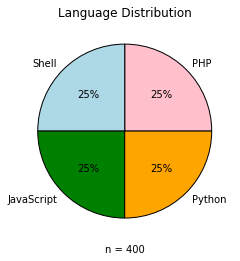

In [8]:
df.language.value_counts().plot.pie(
    colors = ['pink', 'lightblue', 'green', 'orange'], autopct = '%.0f%%')
plt.title("Language Distribution")
plt.ylabel("")
plt.xlabel('n = %d' % df.shape[0])

pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1).set_axis(["n", "percent"], axis = 1, inplace = False)

**Note:** join all Readme and find high count of all words

In [9]:
pd.Series(" ".join(lemmas_df.lemmatized).split()).value_counts().head(10)

http      26064
com       17411
github     9277
org        4476
www        3298
code       3207
img        3049
io         2972
file       2966
source     2849
dtype: int64

**Note:** words within each language

In [10]:
all_words = ' '.join(lemmas_df.lemmatized).split()

python_words = ' '.join(lemmas_df[lemmas_df.language == 'Python'].lemmatized).split()

javascript_words = ' '.join(lemmas_df[lemmas_df.language == 'JavaScript'].lemmatized).split()

php_words = ' '.join(lemmas_df[lemmas_df.language == 'PHP'].lemmatized).split()

shell_words = ' '.join(lemmas_df[lemmas_df.language == 'Shell'].lemmatized).split()

- Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [11]:
all_freq = pd.Series(all_words).value_counts()

python_words_freq = pd.Series(python_words).value_counts()

javascript_words_freq = pd.Series(javascript_words).value_counts()

php_words_freq = pd.Series(php_words).value_counts()

shell_words_freq = pd.Series(shell_words).value_counts()

### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears. When we move on to computing TF-IDF, this basic definition of Term Frequency applies.

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

Raw Count: This is simply the count of the number of occurances of each word.
Frequency: The number of times each word appears divided by the total number of words.
Augmented Frequency: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [12]:
raw_count = (
    pd.concat([all_freq, python_words_freq, javascript_words_freq, php_words_freq, shell_words_freq], axis=1, sort=True)
    .rename(columns={0: "All", 1: "Python", 2: "JavaScript", 3: "PHP", 4: "Shell"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

In [13]:
raw_count.T

,&#9;,aa,aaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaac,aaaaaaaaaai,aaaaaaaad,aaaaaaaaecm,aaaaaaaaerc,...,zybuluo,zyclotrop,zyedidia,zynga,zypper,zyszys,zythum,zyusth,zzxadi,zzz
All,2569,29,5,4,2,1,1,1,1,1,...,1,4,1,3,1,3,1,1,2,2
Python,11,7,0,4,2,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
JavaScript,513,16,1,0,0,1,1,1,1,1,...,1,4,0,0,1,3,1,1,0,0
PHP,288,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
Shell,1757,0,4,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2


**Task** Find record that has &#9

In [14]:
raw_count.sort_values(by="All").tail(10)

,All,Python,JavaScript,PHP,Shell
source,2849,287,2218,89,255
file,2966,731,566,326,1343
io,2972,588,1689,331,364
img,3049,645,1768,353,283
code,3207,679,1907,356,265
www,3298,780,1669,130,719
org,4476,1354,1998,621,503
github,9277,1858,4911,908,1600
com,17411,2960,9148,1613,3690
http,26064,5077,13321,2663,5003


- Most common words overall?
- Most common Python, JavaScript, PHP, Shell words?
- Any words that uniquely Python, JavaScript, PHP, Shell words?

Text(0.5, 1.0, '10 most common words')

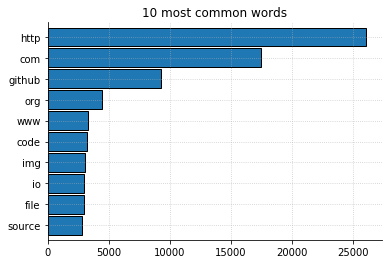

In [15]:
raw_count.sort_values(by='All')['All'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

Text(0.5, 1.0, '10 most common Python words')

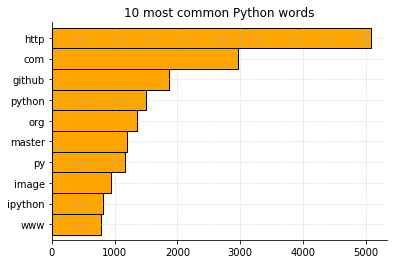

In [16]:
raw_count.sort_values(by='Python').Python.tail(10).plot.barh(width=1, color='Orange')
plt.title('10 most common Python words')

Text(0.5, 1.0, 'What are the most common JavaScript words')

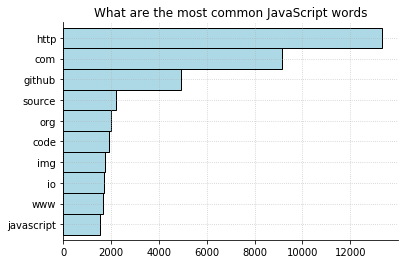

In [17]:
raw_count.sort_values(by='JavaScript').JavaScript.tail(10).plot.barh(width=1, color='lightblue')
plt.title('What are the most common JavaScript words')

Text(0.5, 1.0, 'What are the most common PHP words')

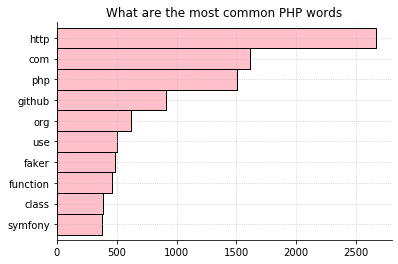

In [18]:
raw_count.sort_values(by='PHP').PHP.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common PHP words')

Text(0.5, 1.0, 'What are the most common Shell words')

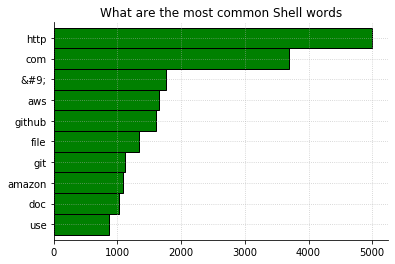

In [19]:
raw_count.sort_values(by='Shell').Shell.tail(10).plot.barh(width=1, color='green')
plt.title('What are the most common Shell words')

In [20]:
raw_count.head()

,All,Python,JavaScript,PHP,Shell
&#9;,2569,11,513,288,1757
aa,29,7,16,6,0
aaa,5,0,1,0,4
aaaaaaaaaaaaaaaaaaaa,4,4,0,0,0
aaaaaaaaaaaaaaaaaaaaa,2,2,0,0,0


In [21]:
tf_df = raw_count[['All']];
tf_df = tf_df.rename(columns={'All': 'raw_count'})
tf_df = tf_df.assign(frequency = lambda lemmas_df: lemmas_df.raw_count / lemmas_df.raw_count.sum())
tf_df = tf_df.assign(augmented_frequency = lambda lemmas_df: lemmas_df.frequency / lemmas_df.frequency.max())
tf_df.frequency.max()

tf_df.sample()


,raw_count,frequency,augmented_frequency
ww,8,0.000013,0.000307


### Ngrams

- Bigrams and visualization of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Bigrams for All Words')

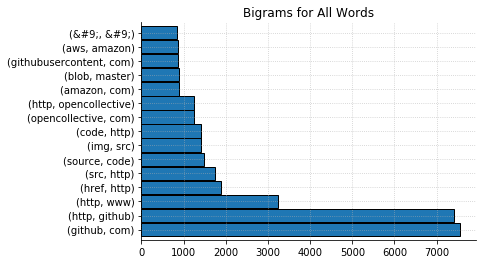

In [22]:
pd.Series(nltk.bigrams(all_words)).value_counts().head(15).plot.barh(width=.95).set_title('Bigrams for All Words')


Text(0.5, 1.0, 'Bigrams for Python Words')

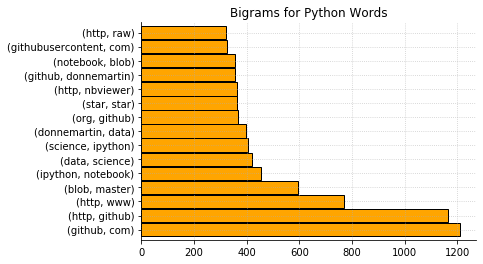

In [23]:
pd.Series(nltk.bigrams(python_words)).value_counts().head(15).plot.barh(width=.95, color='orange').set_title('Bigrams for Python Words')

Text(0.5, 1.0, 'Bigrams for JavaScript Words')

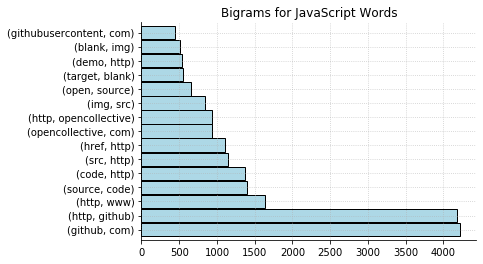

In [24]:
pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15).plot.barh(width=.95, color='lightblue').set_title('Bigrams for JavaScript Words')

Text(0.5, 1.0, 'Bigrams for PHP Words')

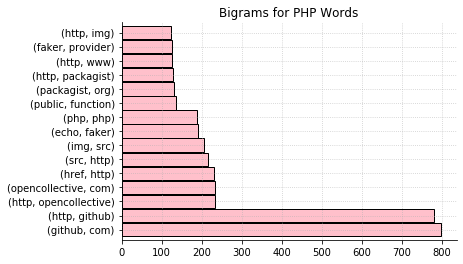

In [25]:
pd.Series(nltk.bigrams(php_words)).value_counts().head(15).plot.barh(width=.95, color='pink').set_title('Bigrams for PHP Words')

Text(0.5, 1.0, 'Bigrams for Shell Words')

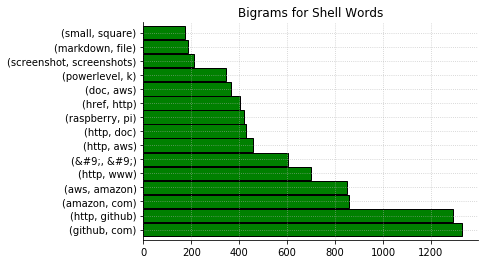

In [26]:
pd.Series(nltk.bigrams(shell_words)).value_counts().head(15).plot.barh(width=.95, color='green').set_title('Bigrams for Shell Words')

- Trigrams and visualization of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Trigrams for All Words')

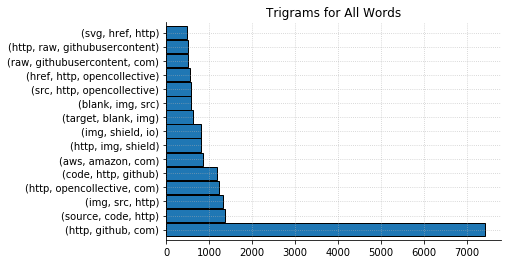

In [27]:
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for All Words')

Text(0.5, 1.0, 'Trigrams for Python Words')

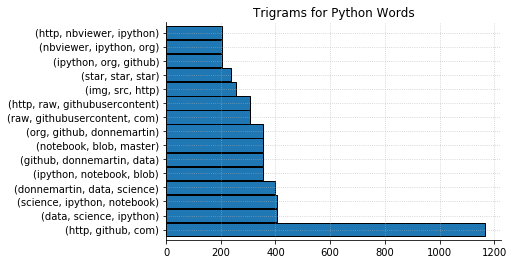

In [28]:
pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Python Words')

Text(0.5, 1.0, 'Trigrams for JavaScript Words')

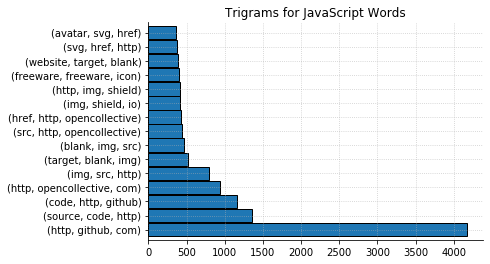

In [29]:
pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for JavaScript Words')

Text(0.5, 1.0, 'Trigrams for PHP Words')

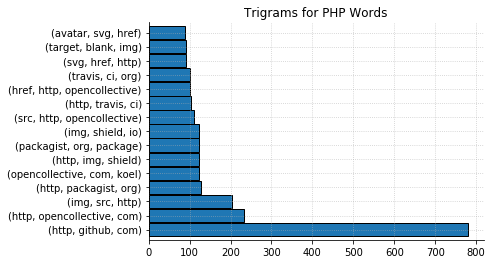

In [30]:
pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for PHP Words')

Text(0.5, 1.0, 'Trigrams for Shell Words')

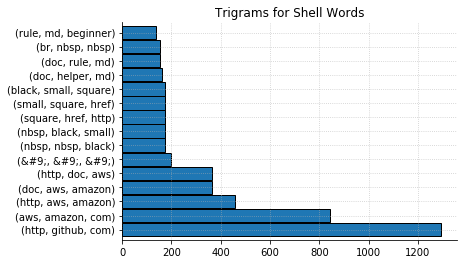

In [31]:
pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Shell Words')

### Document Length

In [32]:
lemmas_df["length"] = lemmas_df.lemmatized.apply(len)

In [33]:
lemmas_df.head()

,language,title,lemmatized,length
0,Python,donnemartin/system-design-primer,english readme md readme ja md readme zh han m...,33781
1,Python,TheAlgorithms/Python,algorithm python donate http img shield io bad...,1433
10,Python,scikit-learn/scikit-learn,mode rst azure travis codecov circleci pythonv...,4094
100,JavaScript,freeCodeCamp/freeCodeCamp,freecodecamp org social banner http amazonaws ...,7758
101,JavaScript,vuejs/vue,p align center href http vuejs org target blan...,13750


In [34]:
mask = lemmas_df.lemmatized.apply(lambda x: '&#9;' in x)

df.original[74]

'# Machine Learning From Scratch\n\n## About\nPython implementations of some of the fundamental Machine Learning models and algorithms from scratch.\n\nThe purpose of this project is not to produce as optimized and computationally efficient algorithms as possible\nbut rather to present the inner workings of them in a transparent and accessible way.\n\n## Table of Contents\n- [Machine Learning From Scratch](#machine-learning-from-scratch)\n  * [About](#about)\n  * [Table of Contents](#table-of-contents)\n  * [Installation](#installation)\n  * [Examples](#examples)\n    + [Polynomial Regression](#polynomial-regression)\n    + [Classification With CNN](#classification-with-cnn)\n    + [Density-Based Clustering](#density-based-clustering)\n    + [Generating Handwritten Digits](#generating-handwritten-digits)\n    + [Deep Reinforcement Learning](#deep-reinforcement-learning)\n    + [Image Reconstruction With RBM](#image-reconstruction-with-rbm)\n    + [Evolutionary Evolved Neural Network](#

In [35]:
df.cleaned[74]

'machine learning scratch python implementations fundamental machine learning models algorithms scratch purpose project produce optimized computationally efficient algorithms possible rather present inner workings transparent accessible way table contents machine learning scratch machine learning scratch table contents table contents installation installation examples examples polynomial regression polynomial regression classification cnn classification cnn density based clustering density based clustering generating handwritten digits generating handwritten digits deep reinforcement learning deep reinforcement learning image reconstruction rbm image reconstruction rbm evolutionary evolved neural network evolutionary evolved neural network genetic algorithm genetic algorithm association analysis association analysis implementations implementations supervised learning supervised learning unsupervised learning unsupervised learning reinforcement learning reinforcement learning deep learn